In [2]:
%%time
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re
import nltk
import json
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
np.random.seed(42)
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import ToktokTokenizer
import nltk, string, re, spacy,unicodedata, random
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')
### Pretrained Word Embeddings

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


CPU times: user 11.8 s, sys: 1.5 s, total: 13.3 s
Wall time: 31.8 s


# Import Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/HOLD/training_data_telugu-hate.xlsx")
test_df= pd.read_excel("/content/drive/MyDrive/Colab Notebooks/HOLD/telugu-hate-speech-test.xlsx")
test_with_label = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/HOLD/telugu-english-test-data-with-labels.xlsx")
print("Total number of training samples:", len(train_df))
print("Total number of test samples:", len(test_df))

Total number of training samples: 4000
Total number of test samples: 499


In [5]:
test_with_label

,1,"ఎన్ని సార్లు అయిన వినాలని ఉంది చిట్టి తల్లి సూపర్ మా,,",non-hate
0,2,ఫ్యూచర్ లో బాగ work out అవుతుంది సూపర్.,non-hate
1,3,ఇది బెండపూడి గవ్నమెంట్ స్టూడెంట్స్ కి మాత్రమే ...,non-hate
2,4,తెలుగులో మాట్లాడినప్పుడు చాలా అందంగా వినసొంపుగ...,non-hate
3,5,సూపర్ సిస్టర్ ఫ్యూచర్ లో రైల్వే లో జాబ్ రావాలన...,non-hate
4,6,వావ్ సూపర్ అమ్మ god bless u తల్లి,non-hate
...,...,...,...
494,496,డబ్బు ఇస్తే నిన్నుకూడ ఎస్తాడు,hate
495,497,నిది చూపించు దెబ్బకి సెట్ ఐపోయిది రోజాకు,hate
496,498,ఏది నాకిన నీది మాత్రం కచ్చితంగా నాకడు చీ రెడ్డి,hate
497,499,ఇప్పుడు నిదిఐన నకుతాడు డబ్బులు ఇస్తే,hate


# Data Set Analysis

In [6]:
print(train_df.shape)
print(test_df.shape)

(4000, 3)
(499, 2)


In [7]:
train_df.head(20)

,S.No,Comments,Label
0,HATE_1001,Thappu chesina vaallaku vanike kaadu inka anni...,hate
1,HATE_1002,Dhusta chaathuryam! Meeru ilantivi enni chesi...,hate
2,HATE_1003,Vetakaram super. Govt ki siggu seram radu. End...,hate
3,HATE_1004,Only rajakiyam ga vadukovatanike ee dharidrapu...,hate
4,HATE_1005,Katam hogaya narayana pedda bokada college,hate
5,HATE_1006,TELUGU DESAM PARTY ONLY GOOD ADMINISTRATION IN...,non-hate
6,HATE_1007,Nenu aite Jabardast show chudadam manesanu TV ...,non-hate
7,HATE_1008,Jagan meeda jaganke visvasam ledu anduke ea lo...,hate
8,HATE_1009,Students tho adukovtam thappu,non-hate
9,HATE_1010,Srinivasa gaaru endukee panikamaalina debate.....,hate


In [8]:
test_df

,1,"ఎన్ని సార్లు అయిన వినాలని ఉంది చిట్టి తల్లి సూపర్ మా,,"
0,2,ఫ్యూచర్ లో బాగ work out అవుతుంది సూపర్.
1,3,ఇది బెండపూడి గవ్నమెంట్ స్టూడెంట్స్ కి మాత్రమే ...
2,4,తెలుగులో మాట్లాడినప్పుడు చాలా అందంగా వినసొంపుగ...
3,5,సూపర్ సిస్టర్ ఫ్యూచర్ లో రైల్వే లో జాబ్ రావాలన...
4,6,వావ్ సూపర్ అమ్మ god bless u తల్లి
...,...,...
494,496,డబ్బు ఇస్తే నిన్నుకూడ ఎస్తాడు
495,497,నిది చూపించు దెబ్బకి సెట్ ఐపోయిది రోజాకు
496,498,ఏది నాకిన నీది మాత్రం కచ్చితంగా నాకడు చీ రెడ్డి
497,499,ఇప్పుడు నిదిఐన నకుతాడు డబ్బులు ఇస్తే


In [9]:
test_df.columns = ['id', 'text']

In [10]:
test_with_label.columns = ['id', 'text', 'label']

In [11]:
test_df.head()

,id,text
0,2,ఫ్యూచర్ లో బాగ work out అవుతుంది సూపర్.
1,3,ఇది బెండపూడి గవ్నమెంట్ స్టూడెంట్స్ కి మాత్రమే ...
2,4,తెలుగులో మాట్లాడినప్పుడు చాలా అందంగా వినసొంపుగ...
3,5,సూపర్ సిస్టర్ ఫ్యూచర్ లో రైల్వే లో జాబ్ రావాలన...
4,6,వావ్ సూపర్ అమ్మ god bless u తల్లి


In [12]:
train_corpus = train_df["Comments"].sum()
test_corpus = test_df['text'].sum()
#test_corpus

In [13]:
import re

train_corpus = train_df["Comments"].sum()
test_corpus = test_df["text"].sum()

# Remove punctuations
chars_to_ignore = '[-,\.:;\'"\!?।]'

train_corpus = re.sub(chars_to_ignore, ' ', train_corpus)
train_vocab = set(train_corpus.split())

test_corpus = re.sub(chars_to_ignore, ' ', test_corpus)
test_vocab = set(test_corpus.split())

oov = test_vocab - train_vocab

print("Number of unique words in training data:", len(train_vocab))
print("Number of unique words in test data:", len(test_vocab))
print("Number of out-of-vocabulary (OOV) words:", len(oov))

Number of unique words in training data: 17097
Number of unique words in test data: 2361
Number of out-of-vocabulary (OOV) words: 1167


In [14]:
filtered_train = train_df[lambda x: x["Comments"].str.contains("[A-Za-z0-9]")]

with pd.option_context('display.max_colwidth', 0):
    display(filtered_train.tail(n=5))

,S.No,Comments,Label
3981,HATE_4982,Roja chala goranga ayipothundh,hate
3983,HATE_4984,Telugu rastrala nayakulu matlade matalaku pichilestundi,hate
3985,HATE_4986,Roja lanj...donga mund.,hate
3988,HATE_4989,"నీ expression చూస్తుంటే ఏదో మర్డర్, రేప్ జరిగినట్టు.",hate
3995,HATE_4996,నిజాయితీపరుడంట....same బాస్ క్వాలిటీస్ చాలా ఉన్నాయంట.,hate


In [15]:
filtered_train.shape

(2664, 3)

In [16]:
print("Total Pure Tamil Sentence = ", train_df.shape[0] - filtered_train.shape[0])

Total Pure Tamil Sentence =  1336


# Preprocessing

In [17]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoj = re.compile("["         # this emoj is to remove all emojis
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations

                           "]+", flags=re.UNICODE)

    text = text.lower()

    url_pattern = r'https?://\S+|www\.\S+'
    text = re.sub(url_pattern, ' ', text)

    text = BeautifulSoup(text, 'html.parser').get_text()
    text = re.sub(r'(https|http|www)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', ' ', text, flags=re.MULTILINE)


    text = emoji_pattern.sub(r' ', text)
    text = emoj.sub(r' ',text)

    text = text.replace('\n', ' ')
    text = text.replace('—', ' ')
    text = text.replace('_', ' ')
    text = text.replace('\r', ' ')
    text = text.replace('\w', ' ')

    text = re.sub(r'(\\)[a-zA-Z]+', ' ',text)

    text = re.sub(r'\s+', ' ', text)  #replace multiple space with single space

    return text

def remove_punctuations(my_str):
    # define punctuation
    #punctuations = '''````£|¢|Ñ+-*/=৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌😀😃😄😁😆😅😂🤣😊😇🙂🙃😉😌😍😘😗😙😚😋😛😝😜🤪🤨🧐🤓😎🤩🥳😏😒😞😔😟😕🙁☹️😣😖😫😩😤😠😡🤬😈👿💀☠️💩🤡👹👺👻👽👾🤖💋💌💘💝💖💗💓💞💕💟❣️💔❤️‍🔥🖤🤍💯💢💥💫💦💨🕳️💣💬👁️‍🗨️🗨️🗯️💭💤👋🤚🖐️✋🖖👌✌️🤞🤟🤘🤙👈👉👆👇☝️✍️👏👏🏻👏🏼👏🏽👏🏾👏🏿👍👍🏻👍🏼👍🏽👍🏾👍🏿👎👎🏻👎🏼👎🏽👎🏾👎🏿✊✊🏻✊🏼✊🏽✊🏾✊🏿🤛🤛🏻🤛🏼🤛🏽🤛🏾🤛🏿🤜🤜🏻🤜🏼🤜🏽🤜🏾🤜🏿🤝🙏🙏🏻🙏🏼🙏🏽🙏🏾🙏🏿✍️💅💅🏻💅🏼💅🏽💅🏾💅🏿🤳💪💪🏻💪🏼💪🏽💪🏾💪🏿🦾🦵🦿🦶👂👂🏻👂🏼👂🏽👂🏾👂🏿👃👃🏻👃🏼👃🏽👃🏾👃🏿👀🧠🫀🫁🦷🦴👅👄🦻🦻🏻🦻🏼🦻🏽🦻🏾🦻🏿👶👶🏻👶🏼👶🏽👶🏾👶🏿🧒🧒🏻🧒🏼🧒🏽🧒🏾🧒🏿👦👦🏻👦🏼👦🏽👦🏾👦🏿👧👧🏻👧🏼👧🏽👧🏾👧🏿🧑🧑🏻🧑🏼🧑🏽🧑🏾🧑🏿👨👨🏻👨🏼👨🏽👨🏾👨🏿👩👩🏻👩🏼👩🏽👩🏾👩🏿🧓🧓🏻🧓🏼🧓🏽🧓🏾🧓🏿👴👴🏻👴🏼👴🏽👴🏾👴🏿👵👵🏻👵🏼👵🏽👵🏾👵🏿👩‍🦰👩🏻‍🦰👩🏼‍🦰👩🏽‍🦰👩🏾‍🦰👩🏿‍🦰👩‍🦱👩🏻‍🦱👩🏼‍🦱👩🏽‍🦱👩🏾‍🦱👩🏿‍🦱👩‍🦳👩🏻‍🦳👩🏼‍🦳👩🏽‍🦳👩🏾‍🦳👩🏿‍🦳👩‍🦲👩🏻‍🦲👩🏼‍🦲👩🏽‍🦲👩🏾‍🦲👩🏿‍🦲👨‍🦰👨🏻‍🦰👨🏼‍🦰👨🏽‍🦰👨🏾‍🦰👨🏿‍🦰👨‍🦱👨🏻‍🦱👨🏼‍🦱👨🏽‍🦱👨🏾‍🦱👨🏿‍🦱👨‍🦳👨🏻‍🦳👨🏼👨🏽‍🦳👨🏾‍🦳👨🏿‍🦳👨‍🦲👨🏻‍🦲👨🏼‍🦲👨🏽‍🦲👨🏾‍🦲👨🏿‍🦲🦰🦱🦳🦲👱‍♀️👱🏻‍♀️❤️‍🩹❤️‍🔥❤️‍🩹🧡💛💚💙💜🤎�￰৷￰'''
    punctuations = '|¢|Ñ+-৳০১২৩৪৫৬৭৮৯।()-[]{}<>@#$%^&*_~—॥🤣⚽️✌😀💉�￰৷￰'
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

In [18]:
train_df['cleanText'] = train_df.Comments.apply(lambda x: preprocessing(str(x)))
test_df['cleanText'] = test_df['text']
test_df['cleanText'] = test_df.cleanText.apply(lambda x: preprocessing(str(x)))

test_with_label['text'] = test_with_label.text.apply(lambda x: preprocessing(str(x)))

In [19]:
train_corpus = train_df["cleanText"].sum()
# train_corpus

In [20]:
train_df.tail(10)

,S.No,Comments,Label,cleanText
3990,HATE_4991,నువ్వు నీ ఓవర్ యాక్షన్ .... మూవీస్ లో ఛాన్స్ క...,hate,నువ్వు నీ ఓవర్ యాక్షన్ .... మూవీస్ లో ఛాన్స్ క...
3991,HATE_4992,ఇక నేను నువ్వు ఇంటర్వ్యూ చేసినా చూడను,hate,ఇక నేను నువ్వు ఇంటర్వ్యూ చేసినా చూడను
3992,HATE_4993,ఒక సారి నీ మీద ఎన్ని కామెంట్లు రాస్తున్నారో చ...,hate,ఒక సారి నీ మీద ఎన్ని కామెంట్లు రాస్తున్నారో చూ...
3993,HATE_4994,తప్పు చేసిన తరువాత వచ్చి ఖమ్ గా నే కూర్చుంటారు,hate,తప్పు చేసిన తరువాత వచ్చి ఖమ్ గా నే కూర్చుంటారు
3994,HATE_4995,చెప్పుతో కొట్టినట్టు సమాధానం ఇచ్చవుగా,hate,చెప్పుతో కొట్టినట్టు సమాధానం ఇచ్చవుగా
3995,HATE_4996,నిజాయితీపరుడంట....same బాస్ క్వాలిటీస్ చాలా ఉన...,hate,నిజాయితీపరుడంట....same బాస్ క్వాలిటీస్ చాలా ఉన...
3996,HATE_4997,ఓహో ఈ నిజాయితీపరుడైన రవి ప్రకాష్ లో పవన్ లక్షణ...,hate,ఓహో ఈ నిజాయితీపరుడైన రవి ప్రకాష్ లో పవన్ లక్షణ...
3997,HATE_4998,వీడీ పేరు రాంగోపాల్ వర్మ! వీడి చేతిలో పడ్డ అమ్...,hate,వీడీ పేరు రాంగోపాల్ వర్మ! వీడి చేతిలో పడ్డ అమ్...
3998,HATE_4999,నువ్వు మాత్రం డబ్బులేస్తే ముష్టి వాడి పక్కన అయ...,hate,నువ్వు మాత్రం డబ్బులేస్తే ముష్టి వాడి పక్కన అయ...
3999,HATE_5000,వచ్చిందండి... మా తుగ్లక్ గాడి మిడ్ నైట్ దెవత,hate,వచ్చిందండి... మా తుగ్లక్ గాడి మిడ్ నైట్ దెవత


In [21]:
train_df.Label.value_counts()

non-hate    2061
hate        1939
Name: Label, dtype: int64

In [22]:
train_df['enc_label'] = train_df['Label'].replace({'hate':1, 'non-hate':0})
test_with_label['enc_label'] = test_with_label['label'].replace({'hate':1, 'non-hate':0})

In [23]:
train_df.enc_label.value_counts()

0    2061
1    1939
Name: enc_label, dtype: int64

# Data Set Visualization

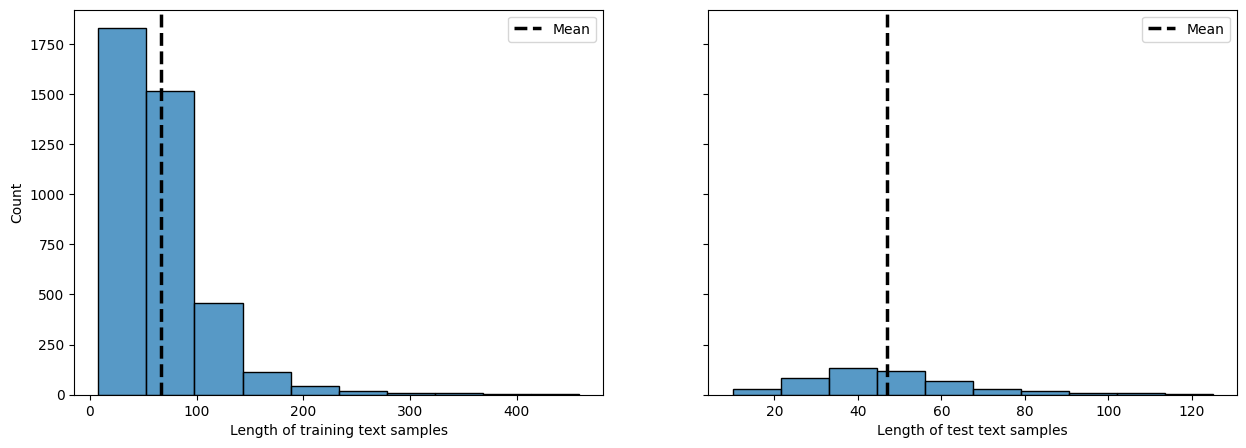

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

train_lengths = train_df["Comments"].str.len()
sns.histplot(ax=axes[0], data=train_lengths, bins=10).set(xlabel="Length of training text samples")
axes[0].axvline(train_lengths.mean(), c="k", ls="--", lw=2.5, label="Mean")
axes[0].legend()

#dev_lengths = dev_df["text"].str.len()
#sns.histplot(ax=axes[1], data=dev_lengths, bins=10).set(xlabel="Length of dev text samples")
#axes[1].axvline(dev_lengths.mean(), c="k", ls="--", lw=2.5, label="Mean")
#axes[1].legend()

test_lengths = test_df["text"].str.len()
sns.histplot(ax=axes[1], data=test_lengths, bins=10).set(xlabel="Length of test text samples")
axes[1].axvline(test_lengths.mean(), c="k", ls="--", lw=2.5, label="Mean")
axes[1].legend()


plt.show()

In [25]:
print(train_lengths.mean());
print(test_lengths.mean());

66.8495
47.08617234468938


In [26]:
dataset = train_df.filter(['cleanText','Label'])
def data_summary(dataset):

    """
        Comments: Comments per class
        words:  words per class
        u_words: unique words per class
    """
    Comments = []
    words = []
    u_words = []
    total_u_words = [word.strip().lower() for t in list(dataset.cleanText) for word in t.strip().split()]
    class_label= [k for k,v in dataset.Label.value_counts().to_dict().items()]
  # find word list
    for label in class_label:
        word_list = [word.strip().lower() for t in list(dataset[dataset.Label==label].cleanText) for word in t.strip().split()]
        counts = dict()
        for word in word_list:
                counts[word] = counts.get(word, 0)+1
        # sort the dictionary of word list
        ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
        # Documents per class
        Comments.append(len(list(dataset[dataset.Label == label].cleanText)))
        # Total Word per class
        words.append(len(word_list))
        # Unique words per class
        u_words.append(len(np.unique(word_list)))

        print("\nClass Name : ",label)
        print("Number of Comments:{}".format(len(list(dataset[dataset.Label==label].cleanText))))
        print("Number of Words:{}".format(len(word_list)))
        print("Number of Unique Words:{}".format(len(np.unique(word_list))))
        print("Most Frequent Words:\n")
        for k,v in ordered[:10]:
              print("{}\t{}".format(k,v))
    print("Total Number of Unique Words:{}".format(len(np.unique(total_u_words))))

    return Comments,words,u_words,class_label

#call the fucntion
Comments,words,u_words,class_names = data_summary(dataset)


Class Name :  non-hate
Number of Comments:2061
Number of Words:21565
Number of Unique Words:9652
Most Frequent Words:

చాలా	149
lo	131
anna	121
ఈ	118
సూపర్	105
ki	104
గారు	104
అన్న	93
sir	92
ga	89

Class Name :  hate
Number of Comments:1939
Number of Words:18251
Number of Unique Words:9178
Most Frequent Words:

ra	142
ki	127
ni	126
lo	120
ga	79
oka	76
na	58
kuda	51
nuvvu	50
నువ్వు	50
Total Number of Unique Words:16421


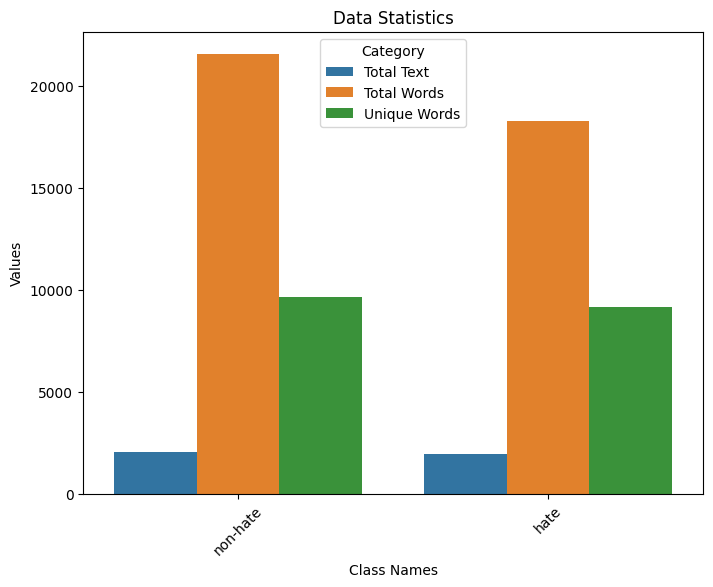

In [27]:
data_matrix = pd.DataFrame({'Total Text':Comments,
                            'Total Words':words,
                            'Unique Words':u_words,
                            'Class Names':class_names})
df = pd.melt(data_matrix, id_vars="Class Names", var_name="Category", value_name="Values")
plt.figure(figsize=(8, 6))
ax = plt.subplot()

sns.barplot(data=df,x='Class Names', y='Values' ,hue='Category')
ax.set_xlabel('Class Names')
ax.set_title('Data Statistics')

ax.xaxis.set_ticklabels(class_names, rotation=45);

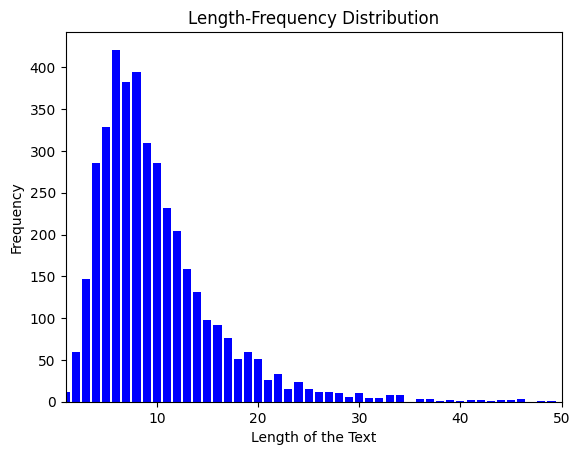

Maximum Length of a Comment: 71
Minimum Length of a Comment: 0
Average Length of a Comment: 10.0


In [28]:
train_df['Comment_length'] = train_df.cleanText.apply(lambda x:len(x.split()))
frequency = dict()
for i in train_df.Comment_length:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(1, 50)
# in this notbook color is not working but it should work.
plt.xlabel('Length of the Text')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()
print(f"Maximum Length of a Comment: {max(train_df.Comment_length)}")
print(f"Minimum Length of a Comment: {min(train_df.Comment_length)}")
print(f"Average Length of a Comment: {round(np.mean(train_df.Comment_length),0)}")

In [29]:
train_df.loc[train_df['Comment_length'] > 40].shape

(22, 6)

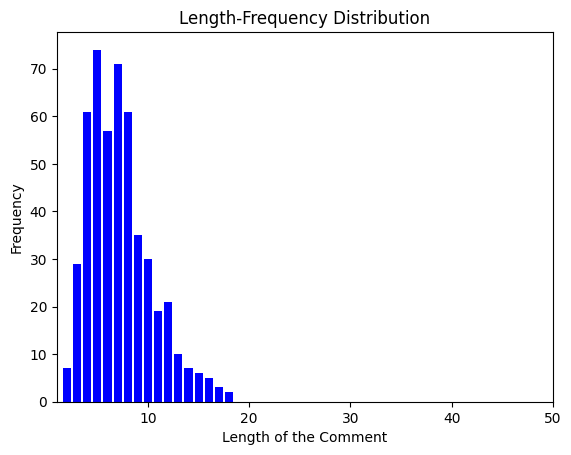

Maximum Length of a Comment: 18
Minimum Length of a Comment: 0
Average Length of a Comment: 7.0


In [30]:
test_df['Comment_length'] = test_df.cleanText.apply(lambda x:len(x.split()))
frequency = dict()
for i in test_df.Comment_length:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(1, 50)
# in this notbook color is not working but it should work.
plt.xlabel('Length of the Comment')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()
print(f"Maximum Length of a Comment: {max(test_df.Comment_length)}")
print(f"Minimum Length of a Comment: {min(test_df.Comment_length)}")
print(f"Average Length of a Comment: {round(np.mean(test_df.Comment_length),0)}")

# Splitting Dataset for Validation

In [31]:
from sklearn.model_selection import train_test_split
Xx_train, Xx_valid, yy_train, yy_valid = train_test_split(train_df['cleanText'], train_df['enc_label'], test_size=0.15, random_state=42, stratify = train_df['enc_label'])

In [32]:
X_train = Xx_train.tolist()
y_train = yy_train.tolist()

X_valid = Xx_valid.tolist()
y_valid = yy_valid.tolist()

X_test = test_with_label['text'].tolist()
y_data_with_label = test_with_label['enc_label'].tolist()

# ML Models

## Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


#TF-IDF
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_valid)
X_test_tfidf = tfidf.transform(X_test)

# Example: Training individual models
model_rf = RandomForestClassifier(n_estimators=1000)  #use class_weight='balanced'
model_rf.fit(X_train_tfidf, y_train)

# Predict on the test set

# Evaluation

## Confusion Matrix by train_test_split validation set (During Contest)

In [45]:
y_pred = model_rf.predict(X_val_tfidf)

accuracy = accuracy_score(y_valid, y_pred)
report = classification_report(y_valid, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)             #estimator 1000--> 0.58      0.57      0.57

Accuracy: 0.7433333333333333
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.83      0.77       309
           1       0.79      0.65      0.71       291

    accuracy                           0.74       600
   macro avg       0.75      0.74      0.74       600
weighted avg       0.75      0.74      0.74       600



## Confusion Matrix after Labeled Test Data revealed (After Contest)

In [46]:
y_pred = model_rf.predict(X_test_tfidf)
accuracy = accuracy_score(y_data_with_label, y_pred)
report = classification_report(y_data_with_label, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)             #estimator 1000--> 0.58      0.57      0.57

Accuracy: 0.5731462925851704
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.70      0.62       249
           1       0.60      0.44      0.51       250

    accuracy                           0.57       499
   macro avg       0.58      0.57      0.57       499
weighted avg       0.58      0.57      0.57       499



## LR

In [47]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression
model_lr = LogisticRegression(solver='liblinear', C=1)
model_lr.fit(X_train_tfidf, y_train)

LogisticRegression(C=1, solver='liblinear')

## Confusion Matrix by train_test_split validation set (During Contest)

In [48]:
# Predict on the test set
y_pred_lr = model_lr.predict(X_val_tfidf)

# Evaluation
accuracy_lr = accuracy_score(y_valid, y_pred_lr)
classification_report_lr = classification_report(y_valid, y_pred_lr)

print(f'Logistic Regression Accuracy: {accuracy_lr}')
print('Classification Report for Logistic Regression:\n', classification_report_lr) # 0.63      0.63      0.63

Logistic Regression Accuracy: 0.7516666666666667
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.76      0.75      0.76       309
           1       0.74      0.75      0.75       291

    accuracy                           0.75       600
   macro avg       0.75      0.75      0.75       600
weighted avg       0.75      0.75      0.75       600



## Confusion Matrix After test dataset revealed (After Contest)

In [49]:
# Predict on the test set
y_pred_lr = model_lr.predict(X_test_tfidf)

# Evaluation
accuracy_lr = accuracy_score(y_data_with_label, y_pred_lr)
classification_report_lr = classification_report(y_data_with_label, y_pred_lr)

print(f'Logistic Regression Accuracy: {accuracy_lr}')
print('Classification Report for Logistic Regression:\n', classification_report_lr) # 0.63      0.63      0.63

Logistic Regression Accuracy: 0.6332665330661322
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.63      0.63      0.63       249
           1       0.63      0.64      0.64       250

    accuracy                           0.63       499
   macro avg       0.63      0.63      0.63       499
weighted avg       0.63      0.63      0.63       499



## SVM

In [38]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Support Vector Machine (SVM)
model_svm = SVC(C=1, class_weight='balanced', kernel='linear')
model_svm.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_svm = model_svm.predict(X_test_tfidf)

# Evaluation
accuracy_svm = accuracy_score(y_data_with_label, y_pred_svm)
classification_report_svm = classification_report(y_data_with_label, y_pred_svm)

print(f'SVM Accuracy: {accuracy_svm}')
print('Classification Report for SVM:\n', classification_report_svm) # 0.65      0.65      0.65

SVM Accuracy: 0.6492985971943888
Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.64      0.67      0.65       249
           1       0.66      0.63      0.64       250

    accuracy                           0.65       499
   macro avg       0.65      0.65      0.65       499
weighted avg       0.65      0.65      0.65       499



## Ensemble Majority Voting

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

#TF-IDF
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_valid)
X_test_tfidf = tfidf.transform(X_test)

# Example: Training individual models
model_rf = RandomForestClassifier(n_estimators=1000)  #use class_weight='balanced' if classes are imbalanced
model_rf.fit(X_train_tfidf, y_train)

model_lr = LogisticRegression(C = 1, class_weight = 'balanced', penalty = 'l2', solver = 'newton-cg', max_iter=1000)
model_lr.fit(X_train_tfidf, y_train)

model_svm = SVC(kernel='linear', C = 1, class_weight = 'balanced')    #kernel='poly'  kernel='rbf'   kernel='sigmoid'
model_svm.fit(X_train_tfidf, y_train)

model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_tfidf, y_train)

DecisionTreeClassifier()

In [51]:
from sklearn.ensemble import VotingClassifier

# Create a list of tuples with model names and trained models
models = [
    ('RandomForest', model_rf),
    ('LogisticRegression', model_lr),
    ('SVM', model_svm),
    ('DecisionTree', model_dt)
]

# Create an ensemble model using VotingClassifier
ensemble_model = VotingClassifier(estimators=models, voting='hard') # 'hard' voting for majority class
ensemble_model.fit(X_train_tfidf, y_train)


VotingClassifier(estimators=[('RandomForest',
                              RandomForestClassifier(n_estimators=1000)),
                             ('LogisticRegression',
                              LogisticRegression(C=1, class_weight='balanced',
                                                 max_iter=1000,
                                                 solver='newton-cg')),
                             ('SVM',
                              SVC(C=1, class_weight='balanced',
                                  kernel='linear')),
                             ('DecisionTree', DecisionTreeClassifier())])

## Confusion Matrix with train_test_split's dev set(during contest)

In [52]:
from sklearn.metrics import accuracy_score, classification_report

# Predictions
y_pred = ensemble_model.predict(X_val_tfidf)
accuracy = accuracy_score(y_valid, y_pred)
report = classification_report(y_valid, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.7383333333333333
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.86      0.77       309
           1       0.80      0.61      0.69       291

    accuracy                           0.74       600
   macro avg       0.75      0.73      0.73       600
weighted avg       0.75      0.74      0.73       600



## Confusion Matrix after test data revealed (after contest)

In [53]:
from sklearn.metrics import accuracy_score, classification_report

# Predictions
y_pred = ensemble_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_data_with_label, y_pred)
report = classification_report(y_data_with_label, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.5951903807615231
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.73      0.64       249
           1       0.63      0.46      0.53       250

    accuracy                           0.60       499
   macro avg       0.60      0.60      0.59       499
weighted avg       0.60      0.60      0.59       499



# Deep Learning


## BiGRU


In [54]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import load_model

In [55]:
tokenizer = Tokenizer(num_words = 20000,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n-',
                      split=' ', char_level=False, oov_token='<oov>', document_count=0)     #tokenization
tokenizer.fit_on_texts(train_df['cleanText'])
word_index = tokenizer.word_index
vocab_size = len(word_index)+1

In [56]:
print(vocab_size)

15151


In [58]:
max_len = 80
# Training Sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
print(len(tokenizer.word_index))
train_pad_sequences =  pad_sequences(train_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Training Sequences :" ,train_pad_sequences.shape)

# Validation Sequences
validation_sequences = tokenizer.texts_to_sequences(X_valid)
validation_pad_sequences =  pad_sequences(validation_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Validation Sequences :" ,validation_pad_sequences.shape)

# Validation Sequences
test_sequences = tokenizer.texts_to_sequences(X_test)
test_pad_sequences =  pad_sequences(test_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of test Sequences :" ,test_pad_sequences.shape)

15150
Number of Training Sequences : (3400, 80)
Number of Validation Sequences : (600, 80)
Number of test Sequences : (499, 80)


In [59]:
num_classes = 2            #### change class number

accuracy_threshold = 0.99

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
# Saved the Best Model
filepath = "/content/drive/MyDrive/Colab Notebooks/HOLD/" + "BiGRU_One.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=False, mode='max')
# callback list
callback_list = [acc_callback, checkpoint]
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(vocab_size, 300, input_length = max_len),
#tf.keras.layers.Conv1D(128, 5, activation='relu'),
#tf.keras.layers.MaxPooling1D(5),
tf.keras.layers.Bidirectional(GRU(units = 200,return_sequences=True,dropout = 0.2)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 300)           4545300   
                                                                 
 bidirectional (Bidirection  (None, 80, 400)           602400    
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 32000)             0         
                                                                 
 dense (Dense)               (None, 1)                 32001     
                                                                 
Total params: 5179701 (19.76 MB)
Trainable params: 5179701 (19.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [62]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(
    train_pad_sequences,
    yy_train,
    epochs=30,
    batch_size=32,
    validation_data=(validation_pad_sequences, yy_valid),
    verbose=1,
    callbacks=callback_list
)
 # as here weight is not using

Epoch 1/30
107/107 [==============================] - ETA: 0s - loss: 0.6165 - accuracy: 0.6315
Epoch 1: val_accuracy improved from -inf to 0.76833, saving model to /content/drive/MyDrive/Colab Notebooks/HOLD/BiGRU_One.h5
107/107 [==============================] - 44s 261ms/step - loss: 0.6165 - accuracy: 0.6315 - val_loss: 0.4920 - val_accuracy: 0.7683
Epoch 2/30
107/107 [==============================] - ETA: 0s - loss: 0.1926 - accuracy: 0.9306
Epoch 2: val_accuracy did not improve from 0.76833
107/107 [==============================] - 9s 83ms/step - loss: 0.1926 - accuracy: 0.9306 - val_loss: 0.6724 - val_accuracy: 0.7300
Epoch 3/30
107/107 [==============================] - ETA: 0s - loss: 0.0379 - accuracy: 0.9912
Reached 99.00% accuracy so we will stop trianing

Epoch 3: val_accuracy did not improve from 0.76833
107/107 [==============================] - 6s 57ms/step - loss: 0.0379 - accuracy: 0.9912 - val_loss: 0.7161 - val_accuracy: 0.6933


### Classification Report before Test Data Revealed with train_test_split Validation Set

In [68]:
# Load the saved model
model = load_model(filepath)
# prediction
y_pred = np.argmax(model.predict(validation_pad_sequences), axis=-1)

print("F1-Score:",f1_score(y_valid,y_pred,average='weighted')*100)
print("Accuracy:",accuracy_score(y_valid,y_pred)*100)

19/19 [==============================] - 1s 9ms/step
F1-Score: 35.01320132013201
Accuracy: 51.5


In [69]:
from sklearn.metrics import classification_report

#Show precision and recall per genre
report = classification_report(y_valid, y_pred)

#print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       309
           1       0.00      0.00      0.00       291

    accuracy                           0.52       600
   macro avg       0.26      0.50      0.34       600
weighted avg       0.27      0.52      0.35       600



### Classification Report after test data revealed

In [65]:
# Load the saved model
model = load_model(filepath)
# prediction
y_pred = np.argmax(model.predict(test_pad_sequences), axis=-1)

print("F1-Score:",f1_score(y_data_with_label,y_pred,average='weighted')*100)
print("Accuracy:",accuracy_score(y_data_with_label,y_pred)*100)

16/16 [==============================] - 2s 12ms/step
F1-Score: 33.22205909144492
Accuracy: 49.899799599198396


In [66]:
from sklearn.metrics import classification_report

#Show precision and recall per genre
report = classification_report(y_data_with_label, y_pred)

#print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       249
           1       0.00      0.00      0.00       250

    accuracy                           0.50       499
   macro avg       0.25      0.50      0.33       499
weighted avg       0.25      0.50      0.33       499



## FastText CNN + BiLSTM

In [70]:
from urllib.request import urlopen
import gzip

# get the vectors
file = gzip.open(urlopen('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ml.300.vec.gz'))

In [71]:
vocab_and_vectors = {}
# put words as dict indexes and vectors as words values
for line in file:
  values = line.split()
  word = values [0].decode('utf-8')
  vector = np.asarray(values[1:], dtype='float32')
  vocab_and_vectors[word] = vector

In [72]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in word_index.items():
  embedding_vector = vocab_and_vectors.get(word)
  # words that cannot be found will be set to 0
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [73]:
num_classes = 2

accuracy_threshold = 0.99

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
# Saved the Best Model
filepath = '/content/drive/MyDrive/Colab Notebooks/HOLD/' +"CNN_BiLSTMModel.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=False, mode='max')
# callback list
callback_list = [acc_callback, checkpoint]
model2 = tf.keras.models.Sequential([
tf.keras.layers.Embedding(vocab_size, 300, weights=[embedding_matrix],trainable=False, input_length = max_len),
tf.keras.layers.Conv1D(128, 2, activation='relu'),
tf.keras.layers.MaxPooling1D(2),
tf.keras.layers.Bidirectional(LSTM(units = 200,return_sequences=True,dropout = 0.2)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(1, activation='sigmoid')])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 80, 300)           4545300   
                                                                 
 conv1d (Conv1D)             (None, 79, 128)           76928     
                                                                 
 max_pooling1d (MaxPooling1  (None, 39, 128)           0         
 D)                                                              
                                                                 
 bidirectional_1 (Bidirecti  (None, 39, 400)           526400    
 onal)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 15600)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [74]:
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model2.fit(train_pad_sequences,
    yy_train,
    epochs= 30,
    batch_size = 32,
    validation_data=(validation_pad_sequences, yy_valid),
    verbose = 1,
    callbacks = callback_list)

Epoch 1/30
107/107 [==============================] - ETA: 0s - loss: 0.6737 - accuracy: 0.5579
Epoch 1: val_accuracy improved from -inf to 0.60833, saving model to /content/drive/MyDrive/Colab Notebooks/HOLD/CNN_BiLSTMModel.h5
107/107 [==============================] - 13s 29ms/step - loss: 0.6737 - accuracy: 0.5579 - val_loss: 0.6542 - val_accuracy: 0.6083
Epoch 2/30
101/107 [===========================>..] - ETA: 0s - loss: 0.6263 - accuracy: 0.6383
Epoch 2: val_accuracy improved from 0.60833 to 0.65833, saving model to /content/drive/MyDrive/Colab Notebooks/HOLD/CNN_BiLSTMModel.h5
107/107 [==============================] - 1s 12ms/step - loss: 0.6271 - accuracy: 0.6385 - val_loss: 0.6262 - val_accuracy: 0.6583
Epoch 3/30
104/107 [============================>.] - ETA: 0s - loss: 0.5925 - accuracy: 0.6581
Epoch 3: val_accuracy improved from 0.65833 to 0.66167, saving model to /content/drive/MyDrive/Colab Notebooks/HOLD/CNN_BiLSTMModel.h5
107/107 [==============================] - 3s

### Classification Report with train_test_split's validation set

In [88]:
# Load the saved model
model2 = load_model('/content/drive/MyDrive/Colab Notebooks/HOLD/' + "CNN_BiLSTMModel.h5")
# prediction
y_pred = np.argmax(model2.predict(validation_pad_sequences), axis=-1)

print("F1-Score:",f1_score(y_valid,y_pred,average='weighted')*100)
print("Accuracy:",accuracy_score(y_valid,y_pred)*100)

19/19 [==============================] - 2s 7ms/step
F1-Score: 35.01320132013201
Accuracy: 51.5


In [89]:
from sklearn.metrics import classification_report

#Show precision and recall per genre
report = classification_report(y_valid, y_pred)

#print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       309
           1       0.00      0.00      0.00       291

    accuracy                           0.52       600
   macro avg       0.26      0.50      0.34       600
weighted avg       0.27      0.52      0.35       600



### Classification Report after labeled test data revealed

In [90]:
# Load the saved model
model2 = load_model('/content/drive/MyDrive/Colab Notebooks/HOLD/' + "CNN_BiLSTMModel.h5")
# prediction
y_pred = np.argmax(model2.predict(test_pad_sequences), axis=-1)

print("F1-Score:",f1_score(y_data_with_label,y_pred,average='weighted')*100)
print("Accuracy:",accuracy_score(y_data_with_label,y_pred)*100)

16/16 [==============================] - 1s 9ms/step
F1-Score: 33.22205909144492
Accuracy: 49.899799599198396


In [91]:
from sklearn.metrics import classification_report

#Show precision and recall per genre
report = classification_report(y_data_with_label, y_pred)

#print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       249
           1       0.00      0.00      0.00       250

    accuracy                           0.50       499
   macro avg       0.25      0.50      0.33       499
weighted avg       0.25      0.50      0.33       499



In [ ]:
# test_pred = np.argmax(model.predict(test_pad_sequences), axis=-1).tolist()

In [ ]:
# test_data['id'] = test_data.index + 1
# run = pd.DataFrame(test_data['id'])
# run['text'] = test_data['text']
# run['label'] = test_pred
# run['label'] = run['label'].apply(actual_label)
# run

## FastText BiGRU

In [81]:
num_classes = 2

accuracy_threshold = 0.99

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
# Saved the Best Model
filepath = '/content/drive/MyDrive/Colab Notebooks/HOLD/' +"BiGRUModel_FastText.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=False, mode='max')
# callback list
callback_list = [acc_callback, checkpoint]
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(vocab_size, 300, weights=[embedding_matrix],trainable=False, input_length = max_len),
# tf.keras.layers.Conv1D(128, 2, activation='relu'),
# tf.keras.layers.MaxPooling1D(2),
tf.keras.layers.Bidirectional(GRU(units = 200,return_sequences=True,dropout = 0.2)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 80, 300)           4545300   
                                                                 
 bidirectional_2 (Bidirecti  (None, 80, 400)           602400    
 onal)                                                           
                                                                 
 flatten_2 (Flatten)         (None, 32000)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 32001     
                                                                 
Total params: 5179701 (19.76 MB)
Trainable params: 634401 (2.42 MB)
Non-trainable params: 4545300 (17.34 MB)
_________________________________________________________________


In [82]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_pad_sequences,
    yy_train,
    epochs= 30,
    batch_size = 32,
    validation_data=(validation_pad_sequences, yy_valid),
    verbose = 1,
    callbacks = callback_list)

Epoch 1/30
107/107 [==============================] - ETA: 0s - loss: 0.6709 - accuracy: 0.5550
Epoch 1: val_accuracy improved from -inf to 0.55333, saving model to /content/drive/MyDrive/Colab Notebooks/HOLD/BiGRUModel_FastText.h5
107/107 [==============================] - 15s 28ms/step - loss: 0.6709 - accuracy: 0.5550 - val_loss: 0.6683 - val_accuracy: 0.5533
Epoch 2/30
104/107 [============================>.] - ETA: 0s - loss: 0.6425 - accuracy: 0.6073
Epoch 2: val_accuracy improved from 0.55333 to 0.64833, saving model to /content/drive/MyDrive/Colab Notebooks/HOLD/BiGRUModel_FastText.h5
107/107 [==============================] - 2s 17ms/step - loss: 0.6422 - accuracy: 0.6085 - val_loss: 0.6391 - val_accuracy: 0.6483
Epoch 3/30
107/107 [==============================] - ETA: 0s - loss: 0.6139 - accuracy: 0.6435
Epoch 3: val_accuracy did not improve from 0.64833
107/107 [==============================] - 2s 17ms/step - loss: 0.6139 - accuracy: 0.6435 - val_loss: 0.6483 - val_accura

### Classification Report with train_test_split validation set

In [92]:
# Load the saved model
model = load_model('/content/drive/MyDrive/Colab Notebooks/HOLD/BiGRUModel_FastText.h5')
# prediction
y_pred = np.argmax(model.predict(validation_pad_sequences), axis=-1)

print("F1-Score:",f1_score(y_valid,y_pred,average='weighted')*100)
print("Accuracy:",accuracy_score(y_valid,y_pred)*100)

19/19 [==============================] - 1s 7ms/step
F1-Score: 35.01320132013201
Accuracy: 51.5


In [93]:
from sklearn.metrics import classification_report

#Show precision and recall per genre
report = classification_report(y_valid, y_pred)

#print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       309
           1       0.00      0.00      0.00       291

    accuracy                           0.52       600
   macro avg       0.26      0.50      0.34       600
weighted avg       0.27      0.52      0.35       600



### Classification Report after labeled test data revealed

In [94]:
# Load the saved model
model = load_model('/content/drive/MyDrive/Colab Notebooks/HOLD/BiGRUModel_FastText.h5')
# prediction
y_pred = np.argmax(model.predict(test_pad_sequences), axis=-1)

print("F1-Score:",f1_score(y_data_with_label,y_pred,average='weighted')*100)
print("Accuracy:",accuracy_score(y_data_with_label,y_pred)*100)

16/16 [==============================] - 1s 9ms/step
F1-Score: 33.22205909144492
Accuracy: 49.899799599198396


In [87]:
from sklearn.metrics import classification_report

#Show precision and recall per genre
report = classification_report(y_data_with_label, y_pred)

#print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       249
           1       0.00      0.00      0.00       250

    accuracy                           0.50       499
   macro avg       0.25      0.50      0.33       499
weighted avg       0.25      0.50      0.33       499



# Pretrained BERT MODELS By Pytorch

In [ ]:
!pip install transformers

In [ ]:
import torch
import transformers
import tensorflow as tf
from transformers import DistilBertTokenizer, DistilBertModel   # for distilBERT

from transformers import BertTokenizer, BertModel     #for mBERT

from transformers import AutoTokenizer, AutoModel    # for pretrained dedicated BERT from Huggingface


# Optional: If you want to fine-tune the model on your specific task
from transformers import DistilBertForSequenceClassification

# Additional imports for dataset handling (if using custom datasets)
from torch.utils.data import Dataset, DataLoader
# Your custom dataset class import, if applicable
# from your_custom_module import NewsDataset

from tqdm import tqdm

## Creating Dataset

In [ ]:

class NewsDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=None, source_to_idx=None, is_labeled=True):
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels = labels if is_labeled else None
        self.source_to_idx = source_to_idx
        self.max_len = max_len
        self.is_labeled = is_labeled

    def __len__(self):
        return len(self.texts)


    def __getitem__(self, index):
        cleanText = self.texts[index]

        inputs = self.tokenizer.encode_plus(
            cleanText,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )

        if self.is_labeled:
            Annotations = self.labels[index]
            return {
                'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
                'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
                'targets': torch.tensor(self.source_to_idx[Annotations], dtype=torch.long)
            }
        else:
            return {
                'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
                'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long)
            }


'''
    def __getitem__(self, index):
        cleanNews = self.texts[index]
        Label = self.labels[index]

        inputs = self.tokenizer.encode_plus(
            cleanNews,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )

        return {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'targets': torch.tensor(self.source_to_idx[Label], dtype=torch.long)
        }   '''

"\n    def __getitem__(self, index):\n        cleanNews = self.texts[index]\n        Label = self.labels[index]\n\n        inputs = self.tokenizer.encode_plus(\n            cleanNews,\n            None,\n            add_special_tokens=True,\n            max_length=self.max_len,\n            padding='max_length',\n            return_token_type_ids=True,\n            truncation=True\n        )\n\n        return {\n            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),\n            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),\n            'targets': torch.tensor(self.source_to_idx[Label], dtype=torch.long)\n        }   "

## Tokenizer

In [ ]:
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

model_name= 'ai4bharat/indic-bert'

tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)        #change transformers.(modify).from_pretrained
MAX_LEN = 256
BATCH_SIZE = 16

unique_sources = ['hate', 'non-hate']
source_to_idx = {source: idx for idx, source in enumerate(unique_sources)}

# dev_set = NewsDataset(dev_df, tokenizer, MAX_LEN, source_to_idx)

In [ ]:
print(source_to_idx)

{'hate': 0, 'non-hate': 1}


In [ ]:
X_train_text = Xx_train.tolist()
y_train_labels = yy_train.tolist()
X_data_with_label_text = XX_data_with_label.tolist()
X_data_with_label_labels = yX_data_with_label.tolist()
X_test_text = test_df['cleanText'].tolist()

In [ ]:
train_set = NewsDataset(X_train_text, y_train_labels, tokenizer=tokenizer, max_len=MAX_LEN, source_to_idx=source_to_idx, is_labeled=True)
valid_set = NewsDataset(X_data_with_label_text, X_data_with_label_labels, tokenizer=tokenizer, max_len=MAX_LEN, source_to_idx=source_to_idx, is_labeled=True)
test_set = NewsDataset(X_test_text, tokenizer=tokenizer, max_len=MAX_LEN, source_to_idx=source_to_idx, is_labeled=False)

In [ ]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

## Creating the source model classifier

In [ ]:
## for multiclass classification and Class imbalance handling
class SourceClassifier(torch.nn.Module):
    def __init__(self, class_weights):             #if no class imbalance remove class_weights argument from __init__ fun
        super(SourceClassifier, self).__init__()
        self.distilbert = transformers.BertModel.from_pretrained(model_name)    #change transformers.(modify).from_pretrained
        self.dropout = torch.nn.Dropout(0.3)
        self.output = torch.nn.Linear(768, len(train_df['enc_label'].unique()))
        self.class_weights = class_weights   #this line is only for class imbalance handling

    def forward(self, ids, mask):
        output = self.distilbert(ids, attention_mask=mask)
        output = self.dropout(output[0][:, 0, :])
        output = self.output(output)
        return output

### Forward Pass

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

train_df['cleanText'] = train_df['cleanText'].astype(str)

class_values = train_df['enc_label'].unique()
class_weights = compute_class_weight('balanced', classes=class_values, y= train_df['enc_label'])

# Convert class weights to tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

# Initialize model with class weights
model = SourceClassifier(class_weights_tensor)
#criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

###IF class imbalance is not present write just 3 lines below and avoid lines above

#model = SourceClassifier()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  ## this enables GPU when it's available else runs in CPU
model.to(device)

You are using a model of type albert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertModel were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['encoder.layer.4.attention.self.value.bias', 'encoder.layer.10.attention.self.value.bias', 'encoder.layer.5.attention.output.LayerNorm.weight', 'encoder.layer.9.attention.self.key.bias', 'encoder.layer.11.output.dense.bias', 'encoder.layer.6.intermediate.dense.bias', 'encoder.layer.2.attention.self.query.bias', 'encoder.layer.8.output.dense.bias', 'encoder.layer.2.attention.output.LayerNorm.weight', 'encoder.layer.9.attention.output.dense.weight', 'encoder.layer.8.attention.output.dense.weight', 'encoder.layer.8.intermediate.dense.weight', 'encoder.layer.6.attention.self.key.bias', 'encoder.layer.9.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.0.attention.self.key.bias', 'encoder.lay

SourceClassifier(
  (distilbert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(200000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

## Training And Testing

In [ ]:
EPOCHS = 10
LEARNING_RATE = 3e-5
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
loss_function = torch.nn.CrossEntropyLoss(weight=class_weights_tensor).to(device)

#train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
#dev_loader = DataLoader(dev_set, batch_size=BATCH_SIZE, shuffle=True)

### See what learning rate to set(Optional)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)        ### Change here 1e-7-->1.7e-6
num_epochs = 3  # Set the number of epochs for LR range testing
best_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        # Process your batch and perform training steps
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(ids.to(device), mask.to(device))
        outputs = outputs.to(device)
        loss = loss_function(outputs, targets.to(device))
        loss.backward()
        optimizer.step()

        # Track the best loss during LR range test
        if loss < best_loss:
            best_loss = loss

            # Update the learning rate in a range suitable for LR test
            optimizer.param_groups[0]['lr'] *= 1.5  # Adjust the LR update factor as needed

# The best learning rate will be around optimizer.param_groups[0]['lr']
print(f"Best learning rate: {optimizer.param_groups[0]['lr']}")

KeyError: 1

In [ ]:

for epoch in range(EPOCHS):
    model.train()
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} - Training")
    for batch in train_bar:
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        train_bar.set_postfix(loss=loss.item())

    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

In [ ]:
dev_bar = tqdm(dev_loader, desc=f"Epoch {epoch+1} - Testing")
for batch in dev_bar:
    ids = batch['ids'].to(device)
    mask = batch['mask'].to(device)
    targets = batch['targets'].to(device)

    with torch.no_grad():
        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        total_loss += loss.item()

        _,predicted = torch.max(outputs, 1)
        total_correct += (predicted == targets).sum().item()
        total_samples += targets.size(0)

        dev_bar.set_postfix(loss=loss.item())

avg_loss = total_loss / len(dev_loader)
accuracy = total_correct / total_samples

print(f"Epoch: {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

# ktrain
# l3cube-pune/indic-sentence-similarity-sbert

In [36]:
!pip install ktrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 17.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 54.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 42.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ktrain: filename=ktrain-0.39.0-py3-none-any.whl size=25319737 sha256=6da22435f06195fc22d14214b935e84e0c5de3525c5cfae3bb69e2926fd39b95
  Stored in directory: /root/.cache/pip/wheels/98/fd/0a/ef6252223f3d2

In [37]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [38]:
import ktrain
from ktrain import text

In [39]:
categories=['hate','non-hate']

In [40]:
import numpy as np
import tensorflow as tf

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [102]:
model_name = "l3cube-pune/indic-sentence-similarity-sbert"
trans = text.Transformer(model_name,maxlen=100,class_names=categories)    #try with mxlen=100

config.json:   0%|          | 0.00/676 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/950M [00:00<?, ?B/s]

In [103]:
train = trans.preprocess_train(X_train,y_train)
valid = trans.preprocess_test(X_valid,y_valid)
test = trans.preprocess_test(X_test,y_data_with_label)

preprocessing train...
language: te
train sequence lengths:
	mean : 10
	95percentile : 21
	99percentile : 33


tokenizer_config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: te
test sequence lengths:
	mean : 10
	95percentile : 21
	99percentile : 34


preprocessing test...
language: te
test sequence lengths:
	mean : 7
	95percentile : 13
	99percentile : 16


In [104]:
model = trans.get_classifier()
learner = ktrain.get_learner(model, train_data=train,val_data=valid, batch_size=16)

In [ ]:
# learner.lr_find(show_plot = True,max_epochs=10)

In [105]:
learner.fit_onecycle(1e-5,15)   # 15 epochs 77(macro) for 1e-5



begin training using onecycle policy with max lr of 1e-05...
Epoch 1/15
213/213 [==============================] - 140s 458ms/step - loss: 0.6914 - accuracy: 0.6238 - val_loss: 0.6865 - val_accuracy: 0.7533
Epoch 2/15
213/213 [==============================] - 92s 432ms/step - loss: 0.6710 - accuracy: 0.7150 - val_loss: 0.6406 - val_accuracy: 0.7433
Epoch 3/15
213/213 [==============================] - 89s 418ms/step - loss: 0.6080 - accuracy: 0.7626 - val_loss: 0.5710 - val_accuracy: 0.7700
Epoch 4/15
213/213 [==============================] - 90s 421ms/step - loss: 0.5346 - accuracy: 0.7909 - val_loss: 0.5427 - val_accuracy: 0.7500
Epoch 5/15
213/213 [==============================] - 89s 416ms/step - loss: 0.4595 - accuracy: 0.8288 - val_loss: 0.4969 - val_accuracy: 0.7800
Epoch 6/15
213/213 [==============================] - 91s 427ms/step - loss: 0.3887 - accuracy: 0.8632 - val_loss: 0.5016 - val_accuracy: 0.7867
Epoch 7/15
213/213 [==============================] - 95s 445ms/st

## Classification Report with train_test_split's validation set

In [106]:
learner.validate(class_names=categories)

19/19 [==============================] - 11s 341ms/step
              precision    recall  f1-score   support

        hate       0.82      0.76      0.79       309
    non-hate       0.76      0.83      0.79       291

    accuracy                           0.79       600
   macro avg       0.79      0.79      0.79       600
weighted avg       0.79      0.79      0.79       600



array([[234,  75],
       [ 50, 241]])

In [107]:
predictor = ktrain.get_predictor(learner.model, preproc=trans)

In [108]:
folder_path = "/content/drive/MyDrive/Colab Notebooks/HOLD"

predictor.save(folder_path+'Transformers_Models'+'/puneIndicSBERT_1eMinus5_16_15')


In [44]:
predictor = ktrain.load_predictor("/content/drive/MyDrive/Colab Notebooks/HOLD/"+'Transformers_Models'+'/puneIndicSBERT_1eMinus5_16_15')

Exception: ignored

## Classification Report after labeled test data revealed

In [109]:
y_pred = predictor.predict(X_test)

In [1]:
# Assuming y_pred is a list or array containing 'hate' and 'non-hate' labels
y_pred = [0 if label == 'hate' else 1 for label in y_pred]

# Now y_pred_mapped contains 0 for 'hate' and 1 for 'non-hate'


NameError: ignored

In [111]:
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(test_with_label['label'], y_pred)
report = classification_report(test_with_label['label'], y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.3106212424849699
Classification Report:
              precision    recall  f1-score   support

        hate       0.31      0.31      0.31       250
    non-hate       0.31      0.31      0.31       249

    accuracy                           0.31       499
   macro avg       0.31      0.31      0.31       499
weighted avg       0.31      0.31      0.31       499



In [ ]:
run = pd.DataFrame(test_df['text'])
run['label'] = y_pred
# run
run['label'].value_counts()

In [ ]:
run.to_csv('/kaggle/working/' +'model1.csv',index = False) # for 3e-5, batch = 16, epochs = 15

In [ ]:
run.to_csv('/kaggle/working/' +'model1.tsv',index = False) # for 3e-5, batch = 16, epochs = 15

In [127]:
model2 = trans.get_classifier()
learner2 = ktrain.get_learner(model, train_data=train,val_data=valid, batch_size=32)
learner2.fit_onecycle(1e-5,10)



begin training using onecycle policy with max lr of 3e-05...
Epoch 1/10
125/125 [==============================] - 117s 763ms/step - loss: 0.6485 - accuracy: 0.6770 - val_loss: 0.5982 - val_accuracy: 0.7114
Epoch 2/10
125/125 [==============================] - 87s 694ms/step - loss: 0.4987 - accuracy: 0.7853 - val_loss: 0.6446 - val_accuracy: 0.6633
Epoch 3/10
125/125 [==============================] - 87s 694ms/step - loss: 0.3658 - accuracy: 0.8580 - val_loss: 0.5417 - val_accuracy: 0.7475
Epoch 4/10
125/125 [==============================] - 87s 699ms/step - loss: 0.2394 - accuracy: 0.9168 - val_loss: 0.6299 - val_accuracy: 0.7335
Epoch 5/10
125/125 [==============================] - 88s 705ms/step - loss: 0.1713 - accuracy: 0.9448 - val_loss: 0.7677 - val_accuracy: 0.7495
Epoch 6/10
125/125 [==============================] - 86s 691ms/step - loss: 0.1326 - accuracy: 0.9578 - val_loss: 0.8519 - val_accuracy: 0.6914
Epoch 7/10
125/125 [==============================] - 86s 692ms/st

In [129]:
learner2.validate(class_names=categories)

16/16 [==============================] - 8s 140ms/step
              precision    recall  f1-score   support

        hate       0.75      0.73      0.74       249
    non-hate       0.74      0.76      0.75       250

    accuracy                           0.75       499
   macro avg       0.75      0.75      0.75       499
weighted avg       0.75      0.75      0.75       499



array([[183,  66],
       [ 60, 190]])

In [130]:
predictor = ktrain.get_predictor(learner2.model, preproc=trans)
ffolder_path = "/content/drive/MyDrive/Colab Notebooks/HOLD"

predictor.save(folder_path+'Transformers_Models'+'/puneIndicSBERT_5eMinus5')

predictor = ktrain.load_predictor(folder_path+'Transformers_Models'+'/puneIndicSBERT_5eMinus5')

In [ ]:
y_pred = predictor.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_data_with_label, y_pred)
report = classification_report(y_data_with_label, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

In [ ]:
y_pred = predictor.predict(X_test)
run = pd.DataFrame(test_df['text'])
run['label'] = y_pred
# run
run['label'].value_counts()

In [ ]:
run.to_csv('/kaggle/working/' +'model2.csv',index = False) # for 3e-5, batch = 16, epochs = 15

In [ ]:
run.to_csv('/kaggle/working/' +'model2.tsv',index = False) # for 3e-5, batch = 16, epochs = 15

##Extras

In [ ]:
import shutil
import os

# Train the model and save the predictor
model = trans.get_classifier()
learner3 = ktrain.get_learner(model, train_data=train, val_data=valid, batch_size=16)
learner3.fit_onecycle(6e-5, 10)
learner3.validate(class_names=categories)

predictor = ktrain.get_predictor(learner3.model, preproc=trans)
folder_path = "/kaggle/working/"
save_folder = 'Transformers_Models/model3'  # Change the folder name to model2

predictor.save(os.path.join(folder_path, save_folder))

# Load the predictor
loaded_predictor = ktrain.load_predictor(os.path.join(folder_path, save_folder))

# Make predictions on test data
y_pred = loaded_predictor.predict(X_test)

# Create a DataFrame with predictions
run = pd.DataFrame(test_df['ఎన్ని సార్లు అయిన వినాలని ఉంది చిట్టి తల్లి సూపర్ మా'])
run['label'] = y_pred

# Save predictions to CSV and TSV
run.to_csv(os.path.join(folder_path, 'model3.csv'), index=False)
run.to_csv(os.path.join(folder_path, 'model3.tsv'), sep='\t', index=False)

# Create a zip archive of the model files
source_folder = os.path.join(folder_path, save_folder)
zip_filename = 'model3.zip'
shutil.make_archive(zip_filename.split('.')[0], 'zip', source_folder)

In [ ]:
import shutil
import os

# Train the model and save the predictor
model = trans.get_classifier()
learner3 = ktrain.get_learner(model, train_data=train, val_data=valid, batch_size=16)
learner3.fit_onecycle(8e-5, 10)
learner3.validate(class_names=categories)

predictor = ktrain.get_predictor(learner3.model, preproc=trans)
folder_path = "/kaggle/working/"
save_folder = 'Transformers_Models/model3'  # Change the folder name to model2

predictor.save(os.path.join(folder_path, save_folder))

# Load the predictor
loaded_predictor = ktrain.load_predictor(os.path.join(folder_path, save_folder))

# Make predictions on test data
y_pred = loaded_predictor.predict(X_test)

# Create a DataFrame with predictions
run = pd.DataFrame(test_df['ఎన్ని సార్లు అయిన వినాలని ఉంది చిట్టి తల్లి సూపర్ మా'])
run['label'] = y_pred

# Save predictions to CSV and TSV
run.to_csv(os.path.join(folder_path, 'model3.csv'), index=False)
run.to_csv(os.path.join(folder_path, 'model3.tsv'), sep='\t', index=False)

# Create a zip archive of the model files
source_folder = os.path.join(folder_path, save_folder)
zip_filename = 'model3.zip'
shutil.make_archive(zip_filename.split('.')[0], 'zip', source_folder)

# Ktrain indicBert

In [ ]:
model_name = 'ai4bharat/indic-bert'
trans = text.Transformer(model_name,maxlen=100,class_names=categories)
train = trans.preprocess_train(X_train,y_train)
valid = trans.preprocess_test(X_data_with_label,X_data_with_label)
model = trans.get_classifier()
Indiclearner = ktrain.get_learner(model, train_data=train,val_data=valid, batch_size=16)

In [ ]:
learner.lr_find(show_plot = True,max_epochs=15)

In [ ]:
Indiclearner.lr_find(show_plot = True,max_epochs=10)

In [ ]:
Indiclearner.fit_onecycle(5e-5,15)

In [ ]:
Indiclearner.validate(class_names=categories)

In [ ]:
predictor = ktrain.get_predictor(Indiclearner.model, preproc=trans)
y_pred = predictor.predict(X_test)
# y_pred

In [ ]:
run = pd.DataFrame(test_df['text'])
run['label'] = y_pred
# run
run['label'].value_counts()

In [ ]:
run.to_csv('/kaggle/working/' +'Tamil_Hate_Indic_72_cw.csv',index = False) # for 3e-5, batch = 16, epochs = 15

# Ktrain mBert

In [48]:
model_name = 'bert-base-multilingual-cased'
trans = text.Transformer(model_name,maxlen=100,class_names=categories)
train = trans.preprocess_train(X_train,y_train)
valid = trans.preprocess_test(X_valid, y_valid)
test = trans.preprocess_test(X_test, y_data_with_label)
model = trans.get_classifier()
CasedmBertlearner = ktrain.get_learner(model, train_data=train,val_data=valid, batch_size=16)

preprocessing train...
language: te
train sequence lengths:
	mean : 10
	95percentile : 21
	99percentile : 33


Is Multi-Label? False
preprocessing test...
language: te
test sequence lengths:
	mean : 10
	95percentile : 21
	99percentile : 34


preprocessing test...
language: te
test sequence lengths:
	mean : 7
	95percentile : 13
	99percentile : 16


In [ ]:
CasedmBertlearner.lr_find(show_plot = True,max_epochs=15)

In [ ]:
CasedmBertlearner.fit_onecycle(2e-5,15)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/15
138/213 [==================>...........] - ETA: 23:56 - loss: 0.6638 - accuracy: 0.6146

In [ ]:
CasedmBertlearner.validate(class_names=categories)

In [ ]:
predictor = ktrain.get_predictor(CasedmBertlearner.model, preproc=trans)
y_pred = predictor.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(test_with_label['label'], y_pred)
report = classification_report(test_with_label['label'], y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

In [ ]:
run = pd.DataFrame(test_df['text'])
run['label'] = y_pred
# run
run['label'].value_counts()
run.to_csv('/kaggle/working/' +'Tamil_Hate_CasedmBert_1_cw.csv',index = False)

# Ktrain XLMR

In [ ]:
model_name = 'xlm-roberta-base'
trans = text.Transformer(model_name,maxlen=64,class_names=categories)
train = trans.preprocess_train(X_train,y_train)
valid = trans.preprocess_test(X_data_with_label,X_data_with_label)
model = trans.get_classifier()
XLlearner = ktrain.get_learner(model, train_data=train,val_data=valid, batch_size=16)

In [ ]:
XLlearner.lr_find(show_plot = True,max_epochs=10)

In [ ]:
XLlearner.fit_onecycle(8e-5,15)

In [ ]:
XLlearner.validate(class_names=categories)

In [ ]:
predictor = ktrain.get_predictor(XLlearner.model, preproc=trans)
y_pred = predictor.predict(X_test)
y_pred

In [ ]:
run = pd.DataFrame(test_df['text'])
run['label'] = y_pred
# run
run['label'].value_counts()
run.to_csv('/kaggle/working/' +'Tamil_Hate_XLMR_1_cw.csv',index = False)

# Ktrain DistilmBert

In [ ]:
model_name = 'distilbert-base-multilingual-cased'
trans = text.Transformer(model_name,maxlen=128,class_names=categories)
train = trans.preprocess_train(X_train,y_train)
valid = trans.preprocess_test(X_data_with_label,X_data_with_label)
model = trans.get_classifier()
Distillearner = ktrain.get_learner(model, train_data=train,val_data=valid, batch_size=16)



In [ ]:
Distillearner.lr_find(show_plot = True,max_epochs=15)

In [ ]:
Distillearner.fit_onecycle(6e-5,15)

In [ ]:
XLlearner.validate(class_names=categories)

In [ ]:
predictor = ktrain.get_predictor(learner2.model, preproc=trans)
y_pred = predictor.predict(X_test)

# Ktrain mBert Uncased

In [ ]:
!pip install ktrain

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import ktrain
from ktrain import text

In [ ]:
model_name = 'bert-base-multilingual-uncased'
trans = text.Transformer(model_name,maxlen=100,class_names=categories)
train = trans.preprocess_train(X_train,y_train)
valid = trans.preprocess_test(X_data_with_label,X_data_with_label)
model = trans.get_classifier()
Distillearner = ktrain.get_learner(model, train_data=train,val_data=valid, batch_size=16)

In [ ]:
Distillearner.lr_find(show_plot = True,max_epochs=15)

In [ ]:
Distillearner.fit_onecycle(6e-5,15)

In [ ]:
XLlearner.validate(class_names=categories)

In [ ]:
predictor = ktrain.get_predictor(learner2.model, preproc=trans)
y_pred = predictor.predict(X_test)

# Ktrain Hate-speech-CNERG/indic-abusive-allInOne-MuRIL

In [ ]:
model_name = 'Hate-speech-CNERG/indic-abusive-allInOne-MuRIL'
trans = text.Transformer(model_name,maxlen=128,class_names=categories)
train = trans.preprocess_train(X_train,y_train)
valid = trans.preprocess_test(X_data_with_label,X_data_with_label)
model = trans.get_classifier()
learner = ktrain.get_learner(model, train_data=train,val_data=valid, batch_size=16)

In [ ]:
learner.lr_find(show_plot = True,max_epochs=15)

# Ktrain l3cube-pune/telugu-bert

In [ ]:
model_name = 'l3cube-pune/telugu-bert'
trans = text.Transformer(model_name,maxlen=128,class_names=categories)
train = trans.preprocess_train(X_train,y_train)
valid = trans.preprocess_test(X_data_with_label,X_data_with_label)
model = trans.get_classifier()
learner = ktrain.get_learner(model, train_data=train,val_data=valid, batch_size=16)

In [ ]:
learner.lr_find(show_plot = True,max_epochs=15)

# Combination Model

In [ ]:
pip install pytorch_pretrained_bert

## mBert + NN

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text
bert_preprocess1 = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3")
bert_encoder1 = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4")

In [ ]:
import tensorflow as tf

In [ ]:
#BERT Layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess1(text_input)
outputs = bert_encoder1(preprocessed_text)


In [ ]:
# Neural network layers
input1 = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
input2 = tf.keras.layers.Dense(100, activation='sigmoid', name="input2")(input1)
input3 = tf.keras.layers.Dense(50, activation='sigmoid', name="input3")(input2)
input4 = tf.keras.layers.Dense(15, activation='sigmoid', name="input5")(input3)
output = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(input4)

# Use inputs and outputs to construct a final model
model1 = tf.keras.Model(inputs=[text_input], outputs = [output])

In [ ]:
model1.summary()

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
model1.fit(X_train, y_train, epochs=10)

In [ ]:
model1.evaluate(X_data_with_label, X_data_with_label)

In [ ]:
y_predicted = model1.predict(X_data_with_label)
y_predicted = y_predicted.flatten()

In [ ]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted.shape

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(X_data_with_label, y_predicted)
cm

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(X_data_with_label, y_predicted))

# mBert + BiLSTM

In [ ]:
bert_preprocess2 = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3")
bert_encoder2 = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4")

In [ ]:
#BERT Layers
text_input = Input(shape=(), dtype=tf.string, name='cleanText')
preprocessed_text2 = bert_preprocess2(text_input)
outputs2 = bert_encoder2(preprocessed_text2)

In [ ]:
from tensorflow.keras.layers import Reshape, Bidirectional, LSTM, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Dropout, Input, concatenate
from tensorflow.keras.models import Model


# BERT embeddings
bert_embedding = outputs2['pooled_output']  # or 'sequence_output' based on your use case
bert_embedding = Dropout(0.2)(bert_embedding)

# Reshape BERT embeddings to a 3D tensor
bert_embedding = Reshape((-1, 768))(bert_embedding)  # Replace 768 with the actual hidden size

# Bidirectional LSTM layer
lstm_output = Bidirectional(LSTM(64, return_sequences=True))(bert_embedding)

# Pooling layers
avg_pooling = GlobalAveragePooling1D()(lstm_output)
max_pooling = GlobalMaxPooling1D()(lstm_output)

# Concatenate and additional dense layers
concat_output = concatenate([avg_pooling, max_pooling])
dense_layer = Dense(128, activation='relu')(concat_output)
dense_layer = Dropout(0.3)(dense_layer)

# Additional Dense layer
dense_layer_2 = Dense(64, activation='relu')(dense_layer)
dense_layer_2 = Dropout(0.3)(dense_layer_2)

# Output layer
output_layer = Dense(1, activation='sigmoid')(dense_layer_2)

# Connect the input and output layers to create the model
model2 = Model(inputs=text_input, outputs=output_layer)


In [ ]:
model2.summary()

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
model2.fit(X_train, y_train, epochs=10)

In [ ]:
model2.evaluate(X_data_with_label, X_data_with_label)

In [ ]:
y_predicted = model2.predict(X_data_with_label)
y_predicted = y_predicted.flatten()

In [ ]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted.shape

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(X_data_with_label, y_predicted)
cm

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(X_data_with_label, y_predicted))

# mBert Uncased + BiLSTM

In [ ]:
bert_preprocess_mbert = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder_mbert = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2")

# BERT Layers
text_input = Input(shape=(), dtype=tf.string, name='cleanText')
preprocessed_text_mbert = bert_preprocess_mbert(text_input)
outputs_mbert = bert_encoder_mbert(preprocessed_text_mbert)

# BERT embeddings
bert_embedding_mbert = outputs_mbert['pooled_output']  # or 'sequence_output' based on your use case
bert_embedding_mbert = Dropout(0.2)(bert_embedding_mbert)

# Reshape BERT embeddings to a 3D tensor
bert_embedding_mbert = Reshape((-1, 512))(bert_embedding_mbert)  # Replace 512 with the actual hidden size

# Bidirectional LSTM layer
lstm_output_mbert = Bidirectional(LSTM(64, return_sequences=True))(bert_embedding_mbert)

# Pooling layers
avg_pooling_mbert = GlobalAveragePooling1D()(lstm_output_mbert)
max_pooling_mbert = GlobalMaxPooling1D()(lstm_output_mbert)

# Concatenate and additional dense layers
concat_output_mbert = concatenate([avg_pooling_mbert, max_pooling_mbert])
dense_layer_mbert = Dense(128, activation='relu')(concat_output_mbert)
dense_layer_mbert = Dropout(0.3)(dense_layer_mbert)

# Additional Dense layer
dense_layer_2_mbert = Dense(64, activation='relu')(dense_layer_mbert)
dense_layer_2_mbert = Dropout(0.3)(dense_layer_2_mbert)

# Output layer
output_layer_mbert = Dense(1, activation='sigmoid')(dense_layer_2_mbert)

# Connect the input and output layers to create the model
model_mbert = Model(inputs=text_input, outputs=output_layer_mbert)

model_mbert.summary()

METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model_mbert.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=METRICS)



In [ ]:
model_mbert.fit(X_train, y_train, epochs=10)

In [ ]:
model_mbert.evaluate(X_data_with_label, X_data_with_label)

y_predicted_mbert = model_mbert.predict(X_data_with_label)
y_predicted_mbert = y_predicted_mbert.flatten()

y_predicted_mbert = np.where(y_predicted_mbert > 0.5, 1, 0)
y_predicted_mbert.shape

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm_mbert = confusion_matrix(X_data_with_label, y_predicted_mbert)
cm_mbert

from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm_mbert, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

print(classification_report(X_data_with_label, y_predicted_mbert))

# BiLSTM + MuRIL BERT

In [ ]:
# bert_encoder2 = hub.KerasLayer("https://tfhub.dev/google/MuRIL-Large/1")
muril_preprocess = hub.KerasLayer("https://tfhub.dev/google/MuRIL_preprocess/1")
muril_encoder = hub.KerasLayer("https://tfhub.dev/google/MuRIL/1")

# BERT Layers
text_input = Input(shape=(), dtype=tf.string, name='cleanText')
preprocessed_text_muril = muril_preprocess(text_input)
outputs_muril = muril_encoder(preprocessed_text_muril)

# BERT embeddings
bert_embedding_muril = outputs_muril['pooled_output']  # or 'sequence_output' based on your use case
bert_embedding_muril = Dropout(0.2)(bert_embedding_muril)

# Reshape BERT embeddings to a 3D tensor
bert_embedding_muril = Reshape((-1, 768))(bert_embedding_muril)  # Replace 768 with the actual hidden size

# Bidirectional LSTM layer
lstm_output_muril = Bidirectional(LSTM(64, return_sequences=True))(bert_embedding_muril)

# Pooling layers
avg_pooling_muril = GlobalAveragePooling1D()(lstm_output_muril)
max_pooling_muril = GlobalMaxPooling1D()(lstm_output_muril)

# Concatenate and additional dense layers
concat_output_muril = concatenate([avg_pooling_muril, max_pooling_muril])
dense_layer_muril = Dense(128, activation='relu')(concat_output_muril)
dense_layer_muril = Dropout(0.3)(dense_layer_muril)

# Additional Dense layer
dense_layer_2_muril = Dense(64, activation='relu')(dense_layer_muril)
dense_layer_2_muril = Dropout(0.3)(dense_layer_2_muril)

# Output layer
output_layer_muril = Dense(1, activation='sigmoid')(dense_layer_2_muril)

# Connect the input and output layers to create the model
model_muril = Model(inputs=text_input, outputs=output_layer_muril)

model_muril.summary()

METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model_muril.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=METRICS)

In [ ]:
model_muril.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_data_with_label, X_data_with_label))

In [ ]:
model_muril.evaluate(X_data_with_label, X_data_with_label)

y_predicted_muril = model_muril.predict(X_data_with_label)
y_predicted_muril = y_predicted_muril.flatten()

y_predicted_muril = np.where(y_predicted_muril > 0.5, 1, 0)
y_predicted_muril.shape

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm_muril = confusion_matrix(X_data_with_label, y_predicted_muril)
cm_muril

from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm_muril, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

print(classification_report(X_data_with_label, y_predicted_muril))

# DL

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import load_model
print("Tensorflow Version:--",tf.version.VERSION)
#print("Keras Version:---",keras.__version__)

## Tokenization

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_data_with_label, y_train, X_data_with_label = train_test_split(train_df['cleanText'], train_df['enc_label'], test_size=0.2, random_state=42)

In [ ]:
tokenizer = Tokenizer(num_words = 20000,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n-',
                      split=' ', char_level=False, oov_token='<oov>', document_count=0)     #tokenization
tokenizer.fit_on_texts(train_df['cleanText'])
word_index = tokenizer.word_index
vocab_size = len(word_index)+1

In [ ]:
print(vocab_size)
print(train_df['enc_label'].dtype)

In [ ]:
max_len = 64
# Training Sequences
train_sequences = tokenizer.texts_to_sequences(X_train)#train_df['cleanText']
print(len(tokenizer.word_index))
train_pad_sequences =  keras.preprocessing.sequence.pad_sequences(train_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Training Sequences :" ,train_pad_sequences.shape)

# Validation Sequences
validation_sequences = tokenizer.texts_to_sequences(X_data_with_label)
validation_pad_sequences =  keras.preprocessing.sequence.pad_sequences(validation_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Validation Sequences :" ,validation_pad_sequences.shape)

In [ ]:
# Test Sequences
test_sequences = tokenizer.texts_to_sequences(X_test)
test_pad_sequences =  keras.preprocessing.sequence.pad_sequences(test_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Test Sequences :" ,test_pad_sequences.shape)

In [ ]:
#from sklearn.utils import class_weight
#class_weights = class_weight.compute_class_weight('balanced' ,np.unique(train_data['enc_label']) ,train_data['enc_label'])

#weight = {i : class_weights[i] for i in range(6)}

In [ ]:
#weight

## Model Definition

In [ ]:
label_encoder = LabelEncoder()
y_train = train_df['enc_label']

In [ ]:
num_classes = 1            #### change class number

accuracy_threshold = 0.99

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
# Saved the Best Model
filepath = "/kaggle/input/hate-offensive/ta_off_BiLSTMModel.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=False, mode='max')
# callback list
callback_list = [acc_callback, checkpoint]
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(vocab_size, 100, input_length = max_len),
#tf.keras.layers.Conv1D(128, 5, activation='relu'),
#tf.keras.layers.MaxPooling1D(5),
tf.keras.layers.Bidirectional(LSTM(units = 100,return_sequences=True,dropout = 0.2)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(1, activation='softmax')])

model.summary()


In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_pad_sequences,
    y_train,
    epochs=15,
    batch_size = 10,
    #validation_split = 0.2,
    verbose =1,
    callbacks = callback_list,
    validation_data=(validation_pad_sequences, X_data_with_label))
    #class_weight = weight)  # as here weight is not using

In [ ]:
# Load the saved model
model = load_model(filepath)
# prediction
y_pred = np.argmax(model.predict(validation_pad_sequences), axis=-1)

print("F1-Score:",f1_score(X_data_with_label,y_pred,average=None)*100)
print("Accuracy:",accuracy_score(X_data_with_label,y_pred)*100)

In [ ]:
from sklearn.metrics import classification_report

#Show precision and recall per genre
report = classification_report(X_data_with_label, y_pred)

#print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)

## Test Set Prediction

In [ ]:
test_pred = np.argmax(model.predict(test_pad_sequences), axis=-1).tolist()
test_pred

In [ ]:
test_df['id'] = test_df.index + 1
run = pd.DataFrame(test_df['id'])
run['text'] = test_df['cleanText']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run

In [ ]:
run.to_csv('/content/drive/MyDrive/Colab Notebooks/NLP Projects/Shared Task 5/tamil_offhate_bilstm.csv',index = False)

# PreTrained Word Embedding(Fasttext)

In [ ]:
from urllib.request import urlopen
import gzip

# get the vectors
file = gzip.open(urlopen('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ml.300.vec.gz'))

In [ ]:
tokenizer = Tokenizer(num_words = 40000,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n-',
                      split=' ', char_level=False, oov_token='<oov>', document_count=0)
tokenizer.fit_on_texts(train_df['cleanText'])
word_index = tokenizer.word_index
vocab_size = len(word_index )+1

In [ ]:
vocab_and_vectors = {}
# put words as dict indexes and vectors as words values
for line in file:
  values = line.split()
  word = values [0].decode('utf-8')
  vector = np.asarray(values[1:], dtype='float32')
  vocab_and_vectors[word] = vector

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in word_index.items():
  embedding_vector = vocab_and_vectors.get(word)
  # words that cannot be found will be set to 0
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
max_len = 80
# Training Sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
print(len(tokenizer.word_index))
train_pad_sequences =  keras.preprocessing.sequence.pad_sequences(train_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Training Sequences :" ,train_pad_sequences.shape)

# Validation Sequences
validation_sequences = tokenizer.texts_to_sequences(X_data_with_label)
validation_pad_sequences =  keras.preprocessing.sequence.pad_sequences(validation_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Validation Sequences :" ,validation_pad_sequences.shape)

In [ ]:
# Test Sequences
test_sequences = tokenizer.texts_to_sequences(test_df['cleanText'])
test_pad_sequences =  keras.preprocessing.sequence.pad_sequences(test_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Test Sequences :" ,test_pad_sequences.shape)

In [ ]:
#from sklearn.utils import class_weight
#class_weights = class_weight.compute_class_weight('balanced',np.unique(train_data['enc_label']) ,train_data['enc_label'])

#weight = {i : class_weights[i] for i in range(5)}

In [ ]:
num_classes = 1

accuracy_threshold = 0.99

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
# Saved the Best Model
filepath = "/content/drive/MyDrive/Colab Notebooks/NLP Projects/Shared Task 5/prt_tamil_off_BiLSTMModel.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=False, mode='max')
# callback list
callback_list = [acc_callback, checkpoint]
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(vocab_size, 300,weights=[embedding_matrix],trainable=False, input_length = max_len),
tf.keras.layers.Conv1D(128, 5, activation='relu'),
tf.keras.layers.MaxPooling1D(5),
tf.keras.layers.Bidirectional(LSTM(units = 128,return_sequences=True,dropout = 0.2)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(5, activation='softmax')])

model.summary()


In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_pad_sequences,
    train_df['enc_label'],
    epochs=200,
    batch_size = 32,
    validation_split = 0.2,
    verbose =1,
    callbacks = callback_list)
    #class_weight = weight)

In [ ]:
from sklearn.metrics import classification_report
# Load the saved model
model = load_model(f'/content/drive/MyDrive/Colab Notebooks/NLP Projects/Shared Task 5/prt_tamil_offhate_BiLSTMModel.h5')
# prediction
y_pred = np.argmax(model.predict(validation_pad_sequences), axis=-1)

#Show precision and recall per genre
report = classification_report(X_data_with_label, y_pred)

#print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)
#print_metrices(X_data_with_label,y_pred)


In [ ]:
test_pred = np.argmax(model.predict(test_pad_sequences), axis=-1).tolist()


In [ ]:
test_df['id'] = test_df.index + 1
run = pd.DataFrame(test_df['id'])
run['text'] = test_df['cleanText']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run


In [ ]:
run.to_csv('/content/drive/MyDrive/Colab Notebooks/NLP Projects/Shared Task 5/tamil_offhate_cnn+bilstm+fasttext.csv',index = False)

In [ ]:
train_df['Label'].value_counts()